In [39]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from models.FNO import FNO2D
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import scipy
import scipy.sparse as sp


In [2]:
from neuralop import LpLoss
M = 1
model_list = [FNO2D(n_modes= 12, hidden_channels=64,in_ch=3,non_linearity=F.gelu) for i in range(M)]
save_dir = "./checkpoints_circletest"
optimizer_list = [torch.optim.Adam(model_list[i].parameters(), lr=1e-3,weight_decay=1e-4) for i in range(M)]

scheduler_list = [torch.optim.lr_scheduler.StepLR(optimizer_list[i],step_size=100,gamma = 0.5) for i in range(M)]

train_loss = LpLoss(d = 2, p = 2, reductions = "sum")




In [3]:
from neuralop.datasets.output_encoder import UnitGaussianNormalizer

x_train = torch.load('./dirichlet_100000_32_x.pt').clone().type(torch.FloatTensor)
y_train = torch.load('./dirichlet_100000_32_y.pt').clone().type(torch.FloatTensor)
y_train = y_train.unsqueeze(1)
print(x_train.shape, y_train.shape)

reduce_dims = list(range(x_train.ndim))
input_encoder = UnitGaussianNormalizer(dim = reduce_dims)
input_encoder.fit(x_train)
# print(input_encoder.mean, input_encoder.std)

reduce_dims = list(range(y_train.ndim))
output_encoder = UnitGaussianNormalizer(dim = reduce_dims)
output_encoder.fit(y_train)


x_train = input_encoder.transform(x_train)
y_train = output_encoder.transform(y_train)


torch.Size([10000, 1, 32, 32]) torch.Size([10000, 1, 32, 32])


In [4]:
from data_transforms.positional_embedding_polar import PositionalEmbedding2D_polar

grid_boundaries = [[0,1],[0,2*np.pi]]
pos_enc = PositionalEmbedding2D_polar(grid_boundaries)
x_train =pos_enc(x_train)

train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_train, y_train),
        batch_size=100,
        shuffle=True
    )
train_loader_list = [train_loader for i in range(M)]


d:\University-local\Imperial\Term_3\Project\.venv\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [5]:
#test set
x_test = torch.load('./dirichlet_100_32_x.pt').clone()
y_test = torch.load('./dirichlet_100_32_y.pt').clone()

y_test = y_test.unsqueeze(1)



x_test = input_encoder.transform(x_test)

y_test = output_encoder.transform(y_test)

x_test = pos_enc(x_test)



test_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(x_test, y_test),
        batch_size=10,
        shuffle=True
    )


test_loader_list = [test_loader for i in range(M)]

eval_loss = train_loss

In [6]:
from callbacks.checkpointcallback_ensemble import CheckpointCallbackEnsemble
from callbacks.loggercallback_ensemble import LoggerCallbackEnsemble
from callbacks.loggercallback import LoggerCallback



ckpt = CheckpointCallbackEnsemble(save_dir=save_dir,
                                       save_freq=10)
logger = LoggerCallbackEnsemble(save_dir=save_dir, n_models = M)

from training.trainer_ensemble import Trainer_Ensemble
trainer = Trainer_Ensemble(model_list=model_list, n_epochs=301,
                  device=device,
                  callbacks=[ckpt,logger],
                  log_test_interval=1,
                  verbose=True)

In [7]:

trainer.train(train_loader_list=train_loader_list,
              test_loaders_list=test_loader_list,
              optimizer_list=optimizer_list,
              scheduler_list=scheduler_list, 
              regularizer=None, 
              training_loss=train_loss,
              eval_losses=eval_loss
              )

Model 0 - Train Epoch: 0 	Loss: 50.954329
Test set: Average loss: 2.2849

Model saved at epoch 0.
Model 0 - Train Epoch: 1 	Loss: 16.536375
Test set: Average loss: 1.3631

Model 0 - Train Epoch: 2 	Loss: 10.939946
Test set: Average loss: 1.0724

Model 0 - Train Epoch: 3 	Loss: 8.106438
Test set: Average loss: 0.7791

Model 0 - Train Epoch: 4 	Loss: 7.148354
Test set: Average loss: 0.7889

Model 0 - Train Epoch: 5 	Loss: 6.338951
Test set: Average loss: 0.6126

Model 0 - Train Epoch: 6 	Loss: 5.833083
Test set: Average loss: 0.5670

Model 0 - Train Epoch: 7 	Loss: 5.323350
Test set: Average loss: 0.5228

Model 0 - Train Epoch: 8 	Loss: 5.110168
Test set: Average loss: 0.5258

Model 0 - Train Epoch: 9 	Loss: 5.290056
Test set: Average loss: 0.6043

Model 0 - Train Epoch: 10 	Loss: 4.777506
Test set: Average loss: 0.5078

Model saved at epoch 10.
Model 0 - Train Epoch: 11 	Loss: 4.395459
Test set: Average loss: 0.5186

Model 0 - Train Epoch: 12 	Loss: 5.240083
Test set: Average loss: 0.40

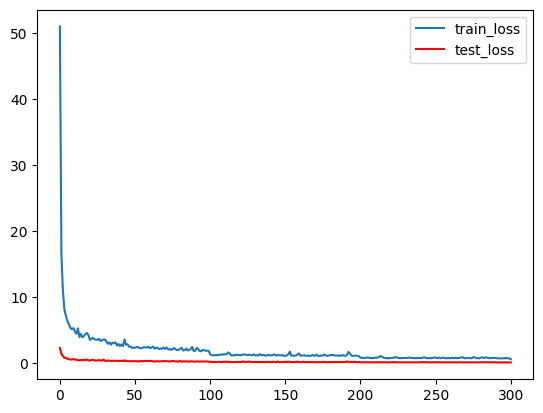

In [8]:
import pandas as pd
losses = [pd.read_csv(f"{save_dir}/loss_{i+1}.csv") for i in range(M)]



for i in range(M):
    plt.plot(np.arange(0,len(losses[i]),1),losses[i]["Train Loss"],"-",label="train_loss")
    plt.plot(np.arange(0,len(losses[i]),1),losses[i]["Test Loss"],"-r",label="test_loss")
    plt.legend()
    plt.show()

In [122]:
def solve_poisson_disk(F, N=50, R=1.0):
    """
    Solves the Poisson equation on the unit disk with given function F.
    
    Parameters:
    - F: Function that takes Cartesian coordinates (X, Y) and returns the value of F at those coordinates.
    - N: Number of radial and angular points in the grid (default is 50).
    - R: Radius of the disk (default is 1.0).
    
    Returns:
    - u: Solution of the Poisson equation on the disk.
    """
    # Grid setup
    r = np.linspace(0, R, N)  # Radial grid
    theta = np.linspace(0, 2*np.pi, N)  # Angular grid
    R, THETA = np.meshgrid(r, theta, indexing='ij')
    X, Y = R * np.cos(THETA), R * np.sin(THETA)  # Cartesian coordinates

    # Function F
    F_values = F(X, Y)

    # Discretization parameters
    dr = r[1] - r[0]
    dtheta = theta[1] - theta[0]

    # Create the sparse matrix system
    N_radial = N - 1
    N_angular = N

    # Initialize matrix A
    diagonals = np.zeros((3, N_radial * N_angular))
    offsets = np.array([-1, 0, 1])

    # Diagonals
    diagonals[0, :] = 1.0
    diagonals[1, :] = -4.0
    diagonals[2, :] = 1.0

    # Offset for the diagonals
    offsets[0] = -1
    offsets[2] = 1

    # Matrix A
    A = sp.diags(diagonals, offsets, shape=(N_radial * N_angular, N_radial * N_angular), format='csc')

    # Vector F
    F_vector = F_values[1:-1, 1:-1].flatten() * (dr**2)

    # Solve the linear system
    u_vector = scipy.sparse.linalg.spsolve(A, F_vector)
    u = np.zeros((N_radial, N_angular))
    u[1:-1, 1:-1] = u_vector.reshape((N_radial, N_angular))

    # Plot the solution
    R_plot, THETA_plot = np.meshgrid(r[1:], theta, indexing='ij')
    X_plot, Y_plot = R_plot * np.cos(THETA_plot), R_plot * np.sin(THETA_plot)
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(X_plot, Y_plot, u, shading='auto')
    plt.colorbar(label='u')
    plt.title('Solution to the Poisson Equation on the Unit Disk')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.axis('equal')
    plt.show()

    return u

In [123]:
grid_size = 32
r = np.linspace(1e-8,1,grid_size)
theta = np.linspace(1e-8,2*np.pi,grid_size)
R, Theta = np.meshgrid(r,theta)

X,Y = R*np.cos(Theta), R*np.sin(Theta)

sample = np.abs(R*np.cos(Theta)) * np.abs(R*np.sin(Theta))
sample = 0* (X) + 1
#sample = (1 - X**2 - Y**2)/4

F = lambda X,Y: X+Y
U = solve_poisson_disk(F,grid_size,1)


sample = torch.tensor(sample)

ValueError: matrix - rhs dimension mismatch ((992, 992) - 900)

torch.Size([1, 1, 32, 32])
tensor([[[[-2.0717e-04, -3.2672e-04, -5.8010e-04,  ..., -4.6143e-04,
           -1.0832e-04, -7.9817e-05],
          [-1.1779e-04, -4.2325e-04, -4.9454e-04,  ..., -5.2282e-04,
           -4.2976e-04, -1.1512e-04],
          [-1.3390e-04, -3.1117e-04, -4.0539e-04,  ...,  5.0852e-04,
            2.8498e-04, -1.4431e-04],
          ...,
          [-1.3030e-04, -3.0833e-04, -3.2239e-04,  ...,  3.3851e-04,
            3.2300e-05, -8.9441e-05],
          [-1.4470e-04, -4.3831e-04, -5.0424e-04,  ...,  3.8467e-06,
           -5.7024e-06, -1.7281e-04],
          [-4.0876e-04, -7.0086e-04, -8.7978e-04,  ..., -1.2414e-03,
           -1.0582e-03, -5.3259e-04]]]], device='cuda:0')


C:\Users\frase\AppData\Local\Temp\ipykernel_14048\3619599187.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]
C:\Users\frase\AppData\Local\Temp\ipykernel_14048\3619599187.py:48: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  fig0 = axs[0].pcolormesh(X,Y,sample.cpu().detach().numpy())
C:\Users\frase\AppData\Local\Temp\ipykernel_14048\3619599187.py:55: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell 

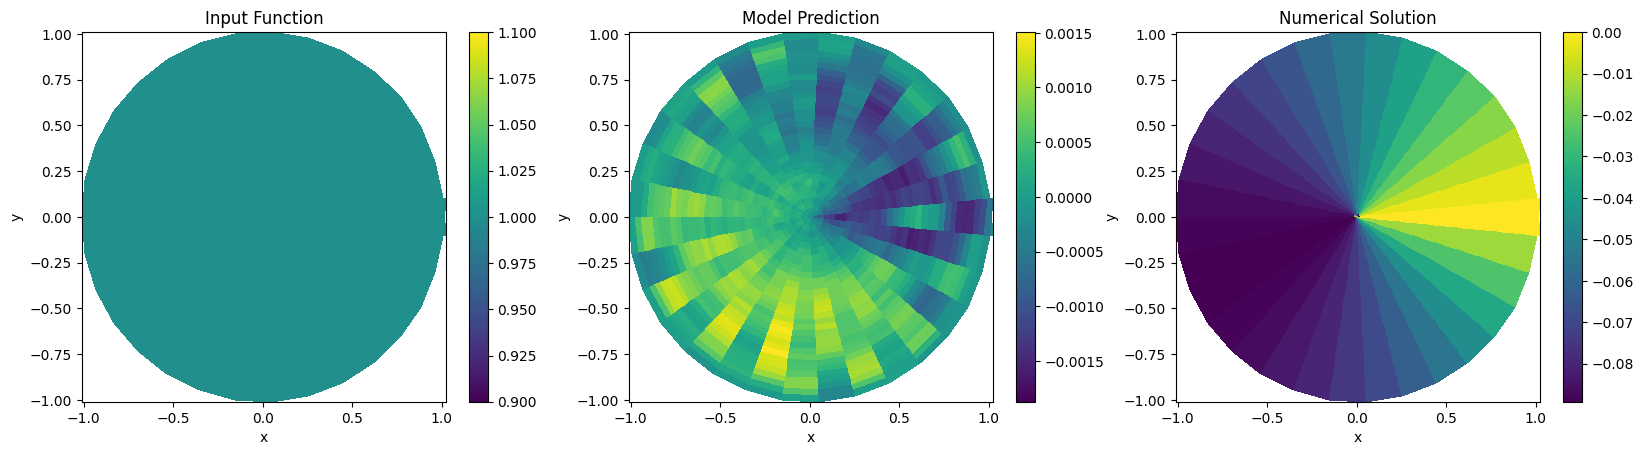

In [114]:
#prediction time for f


for i in range(M): model_list[i].eval().to(device) 



#sample = torch.load("../finput.pt").clone().type(torch.FloatTensor)



sample_scaled = input_encoder.transform(sample.type(torch.FloatTensor))
print(sample_scaled.shape)



#preprocessing

sample_scaled = pos_enc(sample_scaled).to(device)

out = [model_list[i](sample_scaled).to(device) for i in range(M)]
#return to original scale
out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]

mu_unseen = torch.mean(torch.stack([out[i] for i in range(M)]),dim=0).to(device)
print(mu_unseen)
var_unseen = torch.mean(torch.stack([torch.square(out[i] - mu_unseen) for i in range(M)], dim = 0),dim=0)




#mu_unseen = torch.mean(torch.stack([out[i] for i in range(M)]),dim=0).to(device)


U = torch.tensor(U).clone().to(device)
#print(U.shape)
#U_scaled = output_encoder.transform(U.unsqueeze(0).unsqueeze(0).cpu()).to(device)

#print(train_loss(mu_unseen,(U)))



# Plotting
fig, axs = plt.subplots(nrows = 1, ncols =3,gridspec_kw={'width_ratios': [1, 1,1]})
fig.set_figwidth(20)


fig0 = axs[0].pcolormesh(X,Y,sample.cpu().detach().numpy())
fig.colorbar(fig0)
axs[0].set_title("Input Function")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

#prediction
fig1 = axs[1].pcolormesh(X,Y,mu_unseen[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig1)
axs[1].set_title("Model Prediction")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")



#actual
fig2 = axs[2].pcolormesh(X,Y,U.cpu().detach().numpy())

fig.colorbar(fig2)
axs[2].set_title("Numerical Solution")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
plt.show()


C:\Users\frase\AppData\Local\Temp\ipykernel_14048\4106067115.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]
C:\Users\frase\AppData\Local\Temp\ipykernel_14048\4106067115.py:32: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  fig0 = axs[0].pcolormesh(X,Y,input_encoder.inverse_transform(test_loader.dataset[i][0].unsqueeze(0)).to(device)[0,0,:,:].cpu().detach().numpy())
C:\Users\frase\AppData\Local\Temp\ipykernel_14048\4106067115.py:40: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not 

tensor([[[[-9.1909e-04, -6.2969e-02, -1.0572e-01,  ...,  2.4705e-03,
            9.7112e-03,  1.7648e-04],
          [-5.7448e-04, -5.0837e-02, -8.4059e-02,  ...,  4.0196e-03,
            8.0954e-03,  1.1253e-04],
          [-4.2357e-04, -3.4238e-02, -5.5821e-02,  ..., -2.4941e-02,
           -1.3917e-02,  3.1134e-04],
          ...,
          [-2.1216e-04, -7.9316e-02, -1.3683e-01,  ..., -6.5107e-02,
           -3.6959e-02, -8.0929e-04],
          [-3.2891e-04, -7.2551e-02, -1.2424e-01,  ..., -1.5757e-02,
           -6.0135e-03, -9.1783e-04],
          [-6.2371e-05, -6.4371e-02, -1.0683e-01,  ...,  3.0793e-03,
            8.4499e-03, -1.7185e-06]]]], device='cuda:0')


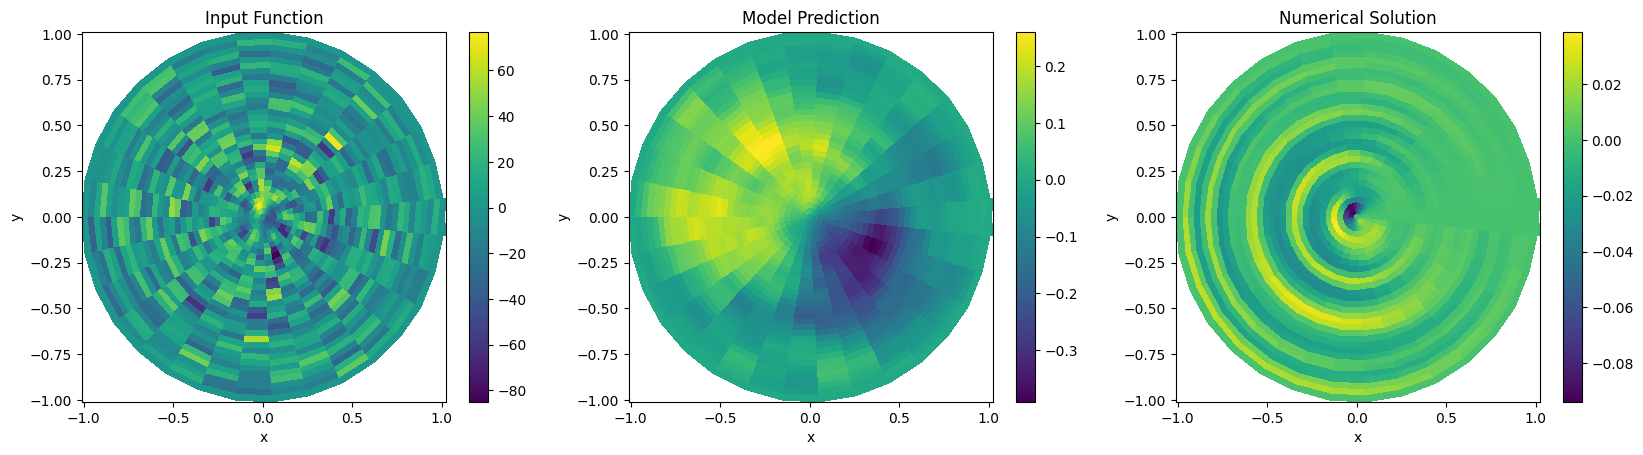

In [107]:
#prediction time
i = np.random.randint(0,100)
j = np.random.randint(0,100)
sample = test_loader.dataset[i][0].unsqueeze(0).to(device)
solution_scaled = test_loader.dataset[i][1].unsqueeze(0)
solution = output_encoder.inverse_transform(solution_scaled).to(device)
solution = solve_poisson_on_unit_disc(sample.cpu().detach().numpy()[0,0,:,:],grid_size,grid_size)

#preprocessing
out = [model_list[i](sample) for i in range(M)]
out = [torch.tensor(output_encoder.inverse_transform(out[i].detach().cpu())).to(device) for i in range(M)]

#var on model scale
mu_seen = torch.mean(torch.stack([out[i] for i in range(M)]),dim=0).to(device)
print(mu_seen)
var_seen = (torch.mean(torch.stack([torch.square(out[i] - mu_seen) for i in range(M)],dim=0), dim = 0))


#print(train_loss(mu_seen,output_encoder.inverse_transform(test_loader.dataset[i][1]).to(device)))
#print(train_loss(mu_seen,solution))

#print(NLL_2(*out,train_loader.dataset[i][1].to(device)))




# Plotting
fig, axs = plt.subplots(nrows = 1, ncols = 3,gridspec_kw={'width_ratios': [1, 1, 1]})
fig.set_figwidth(20)

#fig0 = axs[0].pcolormesh(X,Y,test_loader.dataset[i][0].unsqueeze(0).to(device)[0,0,:,:].cpu().detach().numpy())
fig0 = axs[0].pcolormesh(X,Y,input_encoder.inverse_transform(test_loader.dataset[i][0].unsqueeze(0)).to(device)[0,0,:,:].cpu().detach().numpy())

fig.colorbar(fig0)
axs[0].set_title("Input Function")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

#prediction
fig1 = axs[1].pcolormesh(X,Y,mu_seen[0,0,:,:].cpu().detach().numpy())
fig.colorbar(fig1)
axs[1].set_title("Model Prediction")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")


#actual
fig2 = axs[2].pcolormesh(X,Y,solution)
fig.colorbar(fig2)
axs[2].set_title("Numerical Solution")
axs[2].set_xlabel("x")
axs[2].set_ylabel("y")
plt.show()


In [4]:
grid_size = 32
r = np.linspace(1e-8,1,grid_size)
theta = np.linspace(1e-8,2*np.pi,grid_size)
R, Theta = np.meshgrid(r,theta)

X,Y = R*np.cos(Theta), R*np.sin(Theta)

F = np.abs(R*np.cos(Theta)) * np.abs(R*np.sin(Theta))

C:\Users\frase\AppData\Local\Temp\ipykernel_26488\1949835768.py:11: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  fig0 = axs[0].pcolormesh(X,Y,sample)
C:\Users\frase\AppData\Local\Temp\ipykernel_26488\1949835768.py:18: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  fig1 = axs[1].pcolormesh(X,Y,solution)


Text(0, 0.5, 'y')

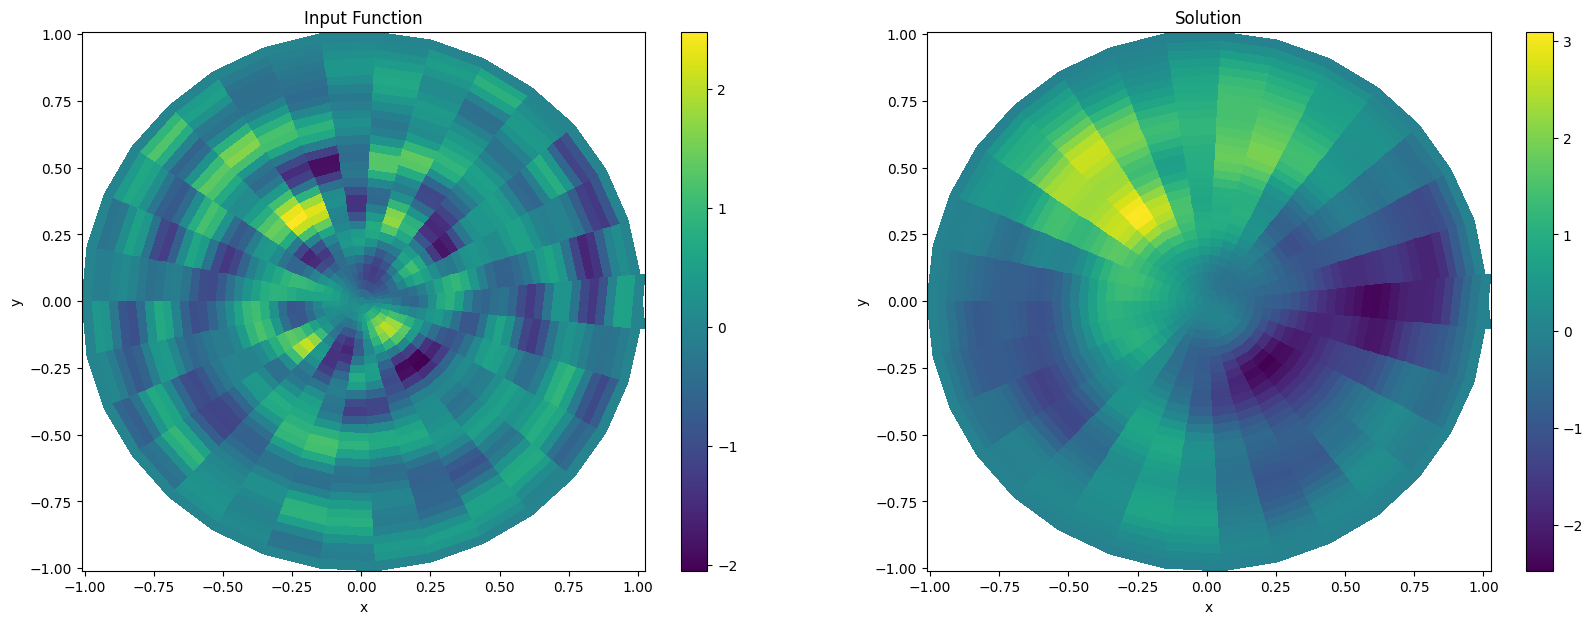

In [5]:
idx = np.random.randint(0,10000)
sample = x_train[idx,0,:,:]
solution = y_train[idx,:,:]


fig, axs = plt.subplots(nrows = 1, ncols = 2,gridspec_kw={'width_ratios': [1, 1]})
fig.set_figwidth(20)
fig.set_figheight(7)


fig0 = axs[0].pcolormesh(X,Y,sample)
fig.colorbar(fig0)
axs[0].set_title("Input Function")
axs[0].set_xlabel("x")
axs[0].set_ylabel("y")

    #prediction
fig1 = axs[1].pcolormesh(X,Y,solution)
fig.colorbar(fig1)
axs[1].set_title("Solution")
axs[1].set_xlabel("x")
axs[1].set_ylabel("y")


In [146]:
X,Y = R*np.cos(Theta), R*np.sin(Theta)
model = FNO2D(n_modes= 12, hidden_channels=64,in_ch=3,non_linearity=F.gelu)

array([[1.00000000e-08, 3.22580742e-02, 6.45161384e-02, ...,
        9.35483872e-01, 9.67741936e-01, 1.00000000e+00],
       [9.79529939e-09, 3.15977495e-02, 6.31954891e-02, ...,
        9.16334460e-01, 9.47932200e-01, 9.79529939e-01],
       [9.18957808e-09, 2.96438091e-02, 5.92876091e-02, ...,
        8.59670208e-01, 8.89314008e-01, 9.18957808e-01],
       ...,
       [9.18957812e-09, 2.96438093e-02, 5.92876094e-02, ...,
        8.59670212e-01, 8.89314012e-01, 9.18957812e-01],
       [9.79529941e-09, 3.15977495e-02, 6.31954892e-02, ...,
        9.16334462e-01, 9.47932202e-01, 9.79529941e-01],
       [1.00000000e-08, 3.22580742e-02, 6.45161384e-02, ...,
        9.35483872e-01, 9.67741936e-01, 1.00000000e+00]])